# Stat222 HW1, Q4 and Q5

Seokjun Choi

*All code blocks are Python scripts.*
*Python script:*
- Q4: https://github.com/letsjdosth/bnp/blob/main/dp_generator.py
- Q5: https://github.com/letsjdosth/bnp/blob/main/gamma_process_generator.py


## Question 4
### 4-(a)

Following Ferguson's original definition, let me implement the sampler of a Dirichlet distribution and Dirichlet process.

In [36]:
from random import gammavariate, seed

class Sampler_Dirichlet:
    def __init__(self, set_seed):
        seed(set_seed)

    def _parameter_support_checker(self, alpha_param):
        for a in alpha_param:
            if a<=0:
                raise ValueError("all elements of alpha should be >0")

    # def sampler(self, alpha_param: list[float]) -> list[float]: #for python 3.9 or later
    def sampler(self, alpha_param: list):
        self._parameter_support_checker(alpha_param)
        beta = 1 #any value
        gamma_samples = [gammavariate(alpha, beta) for alpha in alpha_param]
        sum_gamma_samples = sum(gamma_samples)
        dir_sample = [smpl/sum_gamma_samples for smpl in gamma_samples]
        return dir_sample
    
    def sampler_iter(self, sample_size: int, alpha_param: list):
        samples = []
        for _ in range(sample_size):
            samples.append(self.sampler(alpha_param))
        return samples


class DirichletProcessGenerator:
    def __init__(self, set_seed) -> None:
        seed(set_seed)
        self.dir_generator = Sampler_Dirichlet(set_seed)
    
    def sampler(self, precision:float, center_dist_func, center_dist_sampler, num_grid_pt, grid_starting_pt, grid_ending_pt):
        # grid_starting_pt and grid_ending_pt are truncation points.
        
        grid = [center_dist_sampler() for _ in range(num_grid_pt)]
        grid.sort()
        if grid_starting_pt < grid[0]:
            grid = [grid_starting_pt] + grid
        else:
            raise ValueError("set better grid starting pt")
        dir_param = [center_dist_func(grid[0])]
        for i in range(1, num_grid_pt):
            dir_param.append((center_dist_func(grid[i]) - center_dist_func(grid[i-1])) * precision)
        dir_param.append((1 - center_dist_func(grid[-1])) * precision)

        increments = self.dir_generator.sampler(dir_param)
        cum_dist_val = 0
        sample_path = []
        for inc in increments: #or use np.accumulate
            cum_dist_val += inc
            sample_path.append(cum_dist_val)

        increments = increments + [0]
        if grid[-1] < grid_ending_pt:
            grid.append(grid_ending_pt)
            sample_path.append(1)
        else:
            raise ValueError("set better grid ending pt")
        
        return grid, increments, sample_path

Using Normal(0,1) as the base measure, let me generate sample paths at $\alpha = 0.1, 1, 10,$ and $100$. I will generate five paths for each $\alpha$.

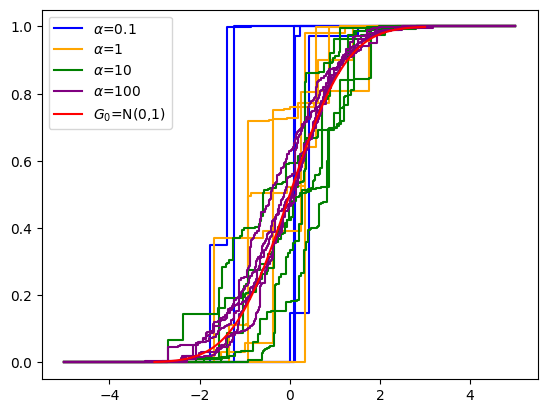

In [37]:
from random import gammavariate
from functools import partial
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

std_norm_cdf = partial(norm.cdf, loc=0, scale=1)
std_norm_sampler = partial(norm.rvs, loc=0, scale=1)

np.random.seed(20230419)    

inst = DirichletProcessGenerator(20230419)

grid, _, path = inst.sampler(0.1, std_norm_cdf, std_norm_sampler, 500, -5, 5)
plt.step(grid, path, where='post', c='blue', label=r'$\alpha$=0.1')
for i in range(4):
    grid, _, path = inst.sampler(0.1, std_norm_cdf, std_norm_sampler, 500, -5, 5)
    plt.step(grid, path, where='post', c='blue')

grid, _, path = inst.sampler(1, std_norm_cdf, std_norm_sampler, 500, -5, 5)
plt.step(grid, path, where='post', c='orange', label=r'$\alpha$=1')
for i in range(4):
    grid, _, path = inst.sampler(1, std_norm_cdf, std_norm_sampler, 500, -5, 5)
    plt.step(grid, path, where='post', c='orange')

grid, _, path = inst.sampler(10, std_norm_cdf, std_norm_sampler, 500, -5, 5)
plt.step(grid, path, where='post', c='green', label=r'$\alpha$=10')
for i in range(4):
    grid, _, path = inst.sampler(10, std_norm_cdf, std_norm_sampler, 500, -5, 5)
    plt.step(grid, path, where='post', c='green')

grid, _, path = inst.sampler(100, std_norm_cdf, std_norm_sampler, 500, -5, 5)
plt.step(grid, path, where='post', c='purple', label=r'$\alpha$=100')
for i in range(4):
    grid, _, path = inst.sampler(100, std_norm_cdf, std_norm_sampler, 500, -5, 5)
    plt.step(grid, path, where='post', c='purple')

plt.plot(np.linspace(-3,3,200), std_norm_cdf(np.linspace(-3,3,200)), c='red', label=r'$G_0$=N(0,1)')
plt.legend()
plt.show()


If $\alpha$ gets larger, the realized paths become closer to the base measure $G_0$ and more continuous. It is coherent with the theoretical result.

Next, let me use Sethuraman's stick-breaking procedure.

In [38]:
from random import betavariate

class DirichletProcessGenerator_StickBreaking:
    def __init__(self, set_seed) -> None:
        seed(set_seed)
        self.atom_loc = None
        self.atom_weight = None

    def atom_sampler(self, precision:float, center_dist_sampler, num_atom: int):
        atom_loc = [center_dist_sampler() for _ in range(num_atom)]
        left_stick_length = 1.0
        atom_weight = []
        for _ in range(num_atom-1):
            portion = betavariate(1, precision)
            weight = portion * left_stick_length
            atom_weight.append(weight)
            left_stick_length = left_stick_length * (1 - portion)
        atom_weight.append(left_stick_length)
        return atom_loc, atom_weight

    def cumulatative_dist_func(self, atom_loc: list, atom_weight: list, trunc_lower: float, trunc_upper: float):
        "Warning: to use `plt.bar`, set `where='post'`"
        #sort
        tuple_list = []
        for loc, weight in zip(atom_loc, atom_weight):
            tuple_list.append((loc, weight))
        
        def sort_key(tup):
            return tup[0]
        tuple_list.sort(key=sort_key)
        
        sample_path = [0]
        increments = [0]
        grid = [trunc_lower]
        cum_dist_val = 0
        for tup in tuple_list:
            cum_dist_val += tup[1]
            grid.append(tup[0])
            increments.append(tup[1])
            sample_path.append(cum_dist_val)
        increments.append(0)
        sample_path.append(1)
        grid = grid + [trunc_upper]

        return grid, increments, sample_path
    
    def mean_var_functional(self, atom_loc:list, atom_weight:list):
        # n = len(atom_loc)
        mean_X = 0
        mean_X2 = 0
        for loc, w in zip(atom_loc, atom_weight):
            mean_X += (loc*w)
            mean_X2 += ((loc)**2 * w)
        var_X = mean_X2 - mean_X**2
        return mean_X, var_X, mean_X2

I will generate five paths for each $\alpha$ again.

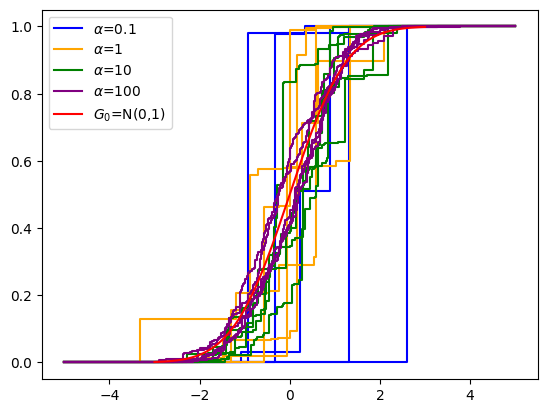

In [39]:
inst = DirichletProcessGenerator_StickBreaking(20230420)

atom_loc, atom_weight = inst.atom_sampler(0.1, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='blue', label=r'$\alpha$=0.1')
for i in range(4):
    atom_loc, atom_weight = inst.atom_sampler(0.1, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='blue')
atom_loc, atom_weight = inst.atom_sampler(1, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='orange', label=r'$\alpha$=1')
for i in range(4):
    atom_loc, atom_weight = inst.atom_sampler(1, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='orange')
atom_loc, atom_weight = inst.atom_sampler(10, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='green', label=r'$\alpha$=10')
for i in range(4):
    atom_loc, atom_weight = inst.atom_sampler(10, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='green')
atom_loc, atom_weight = inst.atom_sampler(100, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='purple', label=r'$\alpha$=100')
for i in range(4):
    atom_loc, atom_weight = inst.atom_sampler(100, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='purple')
plt.plot(np.linspace(-3,3,200), std_norm_cdf(np.linspace(-3,3,200)), c='red', label=r'$G_0$=N(0,1)')
plt.legend()
plt.show()

We can see a similar tendency.
If $\alpha$ gets larger, the realized paths become closer to the base measure $G_0$ with lower variance and less discrete.

### 4-(b)

We can conveniently calculate mean and variance functional using the stick-breaking DP sampler.
I will generate 1000 DP sample paths at $\alpha=1$ and construct histograms of the mean functional and the variance functional.

To check whether the simulation is right or wrong, I paste true analytic results next to the simulated results.
Please see the console output in front of the plots.

E[mu(G)]: sim: 0.003055358505160398  true: 0
Var[mu(G)]: sim: 0.4694016460782747  true: 0.5
E[integral x^2 dG]: sim: 0.9460196738716782  true: 1
E[sigma^2(G)]: sim: 0.47660869257780836  true: 0.5


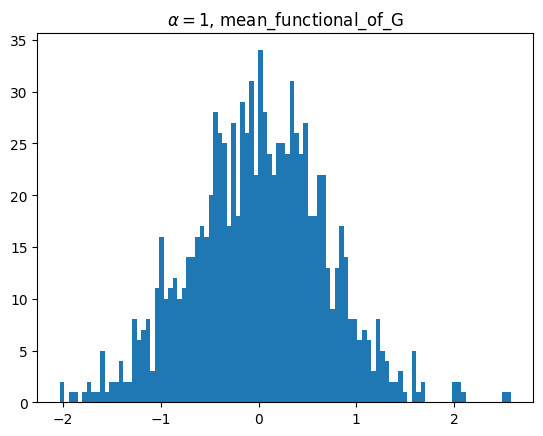

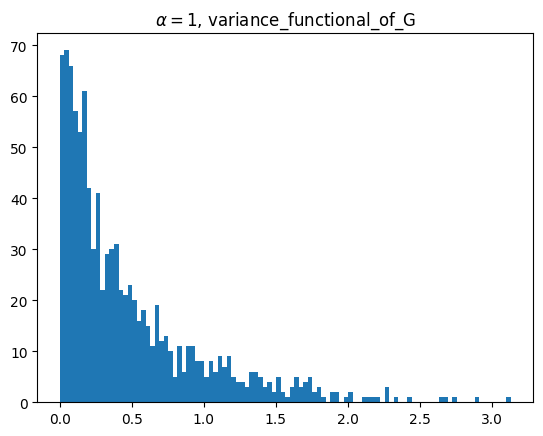

In [40]:
inst = DirichletProcessGenerator_StickBreaking(20230419)
mean_vec = []
var_vec = []
X2_vec = []
alpha = 1
for i in range(1000):
    atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 1000)
    mean_val, var_val, X2_val = inst.mean_var_functional(atom_loc, atom_weight)
    mean_vec.append(mean_val)
    var_vec.append(var_val)
    X2_vec.append(X2_val)

print("E[mu(G)]:", "sim:", np.mean(mean_vec), " true:", 0)
print("Var[mu(G)]:", "sim:", np.var(mean_vec), " true:", 1/(alpha+1))
print("E[integral x^2 dG]:", "sim:", np.mean(X2_vec), " true:", 1)
print("E[sigma^2(G)]:", "sim:", np.mean(var_vec), " true:", alpha/(alpha+1))

plt.hist(mean_vec, bins=100)
plt.title(r"$\alpha=1$, mean_functional_of_G")
plt.show()
plt.hist(var_vec, bins=100)
plt.title(r"$\alpha=1$, variance_functional_of_G")
plt.show()

How about $\alpha=10$?

E[mu(G)]: sim: 0.007345420569709376  true: 0
Var[mu(G)]: sim: 0.0901735805471018  true: 0.09090909090909091
E[integral x^2 dG]: sim: 0.9999087042883678  true: 1
E[sigma^2(G)]: sim: 0.90968116853792  true: 0.9090909090909091


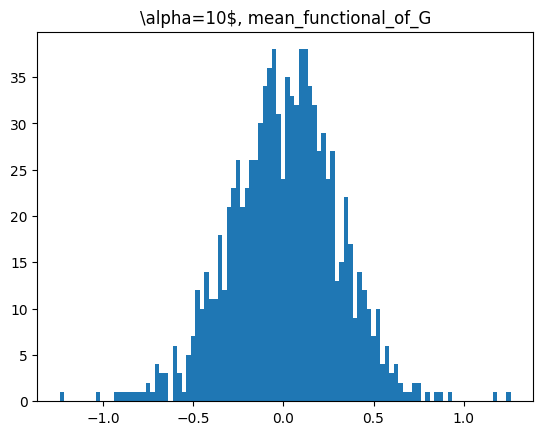

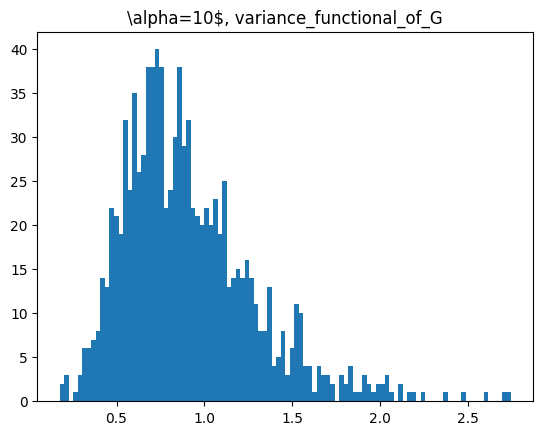

In [41]:
inst = DirichletProcessGenerator_StickBreaking(20230419)
mean_vec = []
var_vec = []
X2_vec = []
alpha = 10
for i in range(1000):
    atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 1000)
    mean_val, var_val, X2_val = inst.mean_var_functional(atom_loc, atom_weight)
    mean_vec.append(mean_val)
    var_vec.append(var_val)
    X2_vec.append(X2_val)

print("E[mu(G)]:", "sim:", np.mean(mean_vec), " true:", 0)
print("Var[mu(G)]:", "sim:", np.var(mean_vec), " true:", 1/(alpha+1))
print("E[integral x^2 dG]:", "sim:", np.mean(X2_vec), " true:", 1)
print("E[sigma^2(G)]:", "sim:", np.mean(var_vec), " true:", alpha/(alpha+1))

plt.hist(mean_vec, bins=100)
plt.title(r"\alpha=10$, mean_functional_of_G")
plt.show()
plt.hist(var_vec, bins=100)
plt.title(r"\alpha=10$, variance_functional_of_G")
plt.show()

Note that $Var(\mu(G))$ got lower when $\alpha$ increased.
(Interestingly the variance functional got large!)

Everything looks good.

### 4-(c)

Following the algorithm on the note, let me generate sample paths of MDP.
I will try
- $\alpha \sim$ gamma(1,1), with mean 1 and var 1
- $\alpha \sim$ gamma(10,10), with mean 10 and var 1/10
- $\alpha \sim$ gamma(100,10), with mean 10, and var 1
- $\alpha \sim$ gamma(10,1), with mean 10 and var 10

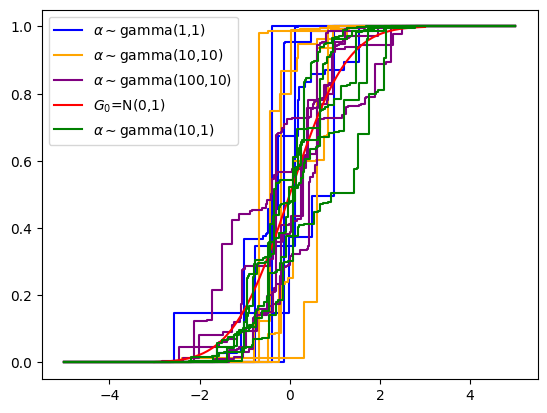

In [42]:

inst = DirichletProcessGenerator_StickBreaking(20230419)

alpha_prior_shape = 1
alpha_prior_rate = 1 #mean 1, var 1
alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='blue', label=r'$\alpha\sim$gamma(1,1)')
for i in range(4):
    alpha_prior_shape = 1
    alpha_prior_rate = 1 #mean 1, var 1
    alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
    atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='blue')

alpha_prior_shape = 10
alpha_prior_rate = 10 #mean 1, var 1/10
alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='orange', label=r'$\alpha\sim$gamma(10,10)')
for i in range(4):
    alpha_prior_shape = 10
    alpha_prior_rate = 10 #mean 1, var 1/10
    alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
    atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='orange')


alpha_prior_shape = 100
alpha_prior_rate = 10 #mean 10, var 1
alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='purple', label=r'$\alpha\sim$gamma(100,10)')
for i in range(4):
    alpha_prior_shape = 100
    alpha_prior_rate = 10 #mean 10, var 1
    alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
    atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='purple')
plt.plot(np.linspace(-3,3,200), std_norm_cdf(np.linspace(-3,3,200)), c='red', label=r'$G_0$=N(0,1)')

alpha_prior_shape = 10
alpha_prior_rate = 1 #mean 10, var 10
alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
plt.step(grid, path, where='post', c='green', label=r'$\alpha\sim$gamma(10,1)')
for i in range(4):
    alpha_prior_shape = 10
    alpha_prior_rate = 1 #mean 10, var 10
    alpha = gammavariate(alpha_prior_shape, 1/alpha_prior_rate)
    atom_loc, atom_weight = inst.atom_sampler(alpha, std_norm_sampler, 500)
    grid, _, path = inst.cumulatative_dist_func(atom_loc, atom_weight, -5, 5)
    plt.step(grid, path, where='post', c='green')

plt.legend()
plt.show()


The mean of $\alpha$ has vast effects. The blue realizations are more discrete and dispersed.
But the impact of variance of $\alpha$ is unclear when we only look at the above five realizations for each case.
Intuitively, we may see various types (or behaviors) of realized paths if the variance increases.
Perhaps the number of repetitions may be too low to see this behavior. (or my intuition may be wrong.)

## Question 5

Following the algorithm in the note, I implement the gamma process sampler.

In [43]:
from math import exp

class GammaProcess_from_NeutralToTheRightProcess:
    "gamma process generator using NTTR"
    #no truncation: generated cdf may not be 1 at the end point of the grid
    def __init__(self, set_seed) -> None:
        seed(set_seed)
    
    def sampler(self, precision:float, baseline_cum_hazard_func, grid:list):
        baseline_cumhazard_increment = []
        
        # generate Z, cumulative hazard path
        generated_hazard_list = []
        
        increment_0 = baseline_cum_hazard_func(grid[0]) - baseline_cum_hazard_func(0)
        baseline_cumhazard_increment.append(increment_0)
        generated_hazard_0 = gammavariate(precision*increment_0, 1/precision)
        generated_hazard_list.append(generated_hazard_0)
        
        cum_hazard_sum = generated_hazard_0
        generated_cum_hazard = [generated_hazard_0]
        for i in range(1, len(grid)):
            increment_i = baseline_cum_hazard_func(grid[i]) - baseline_cum_hazard_func(grid[i-1])
            baseline_cumhazard_increment.append(increment_i)
            generated_hazard = gammavariate(precision*increment_i, 1/precision)
            generated_hazard_list.append(generated_hazard)
            cum_hazard_sum += generated_hazard
            generated_cum_hazard.append(cum_hazard_sum)
    
        # construct F, distribution function path
        generated_dist = [0]
        for r in generated_hazard_list:
            F_t_1 = generated_dist[-1]
            Ft = F_t_1 + (1 - exp(-r))*(1 - F_t_1)
            generated_dist.append(Ft)
        
        return [0]+grid, [0]+generated_cum_hazard, generated_dist

With baseline cumulative hazard function $Z_0(t)=t$ (which is of the exponential distribution's),
I generate 10 sample paths for each $c = 0.1, 1, 10,$ and $100$.

You can find the used $c$ value on the title of each plot.

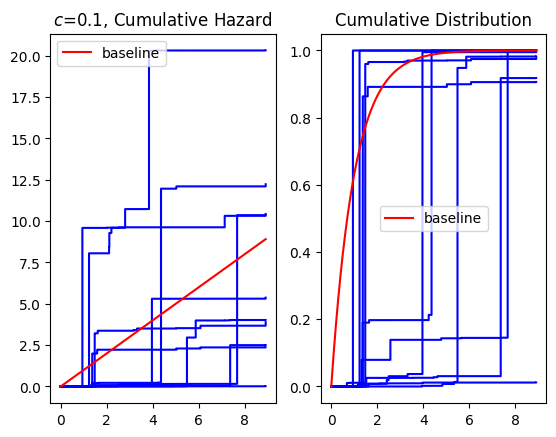

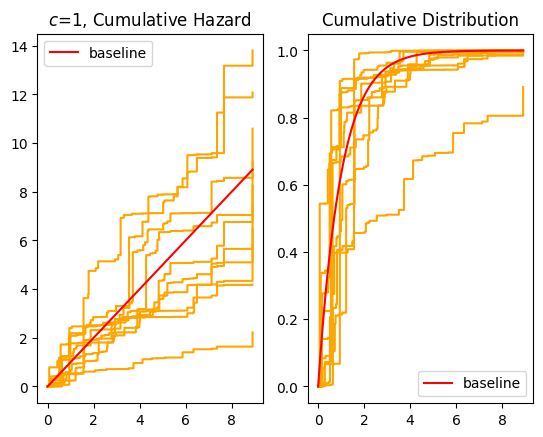

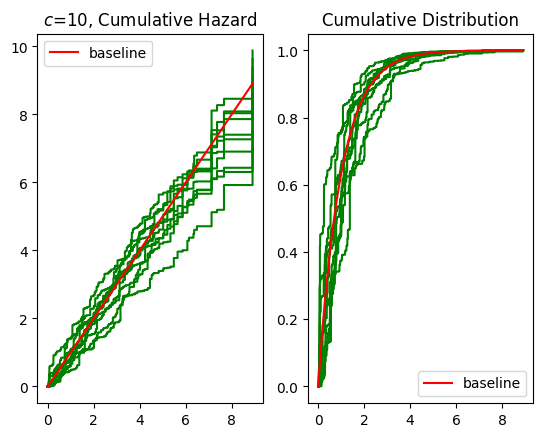

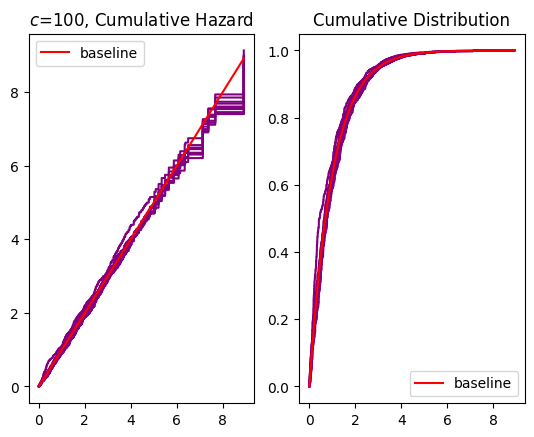

In [44]:
def exp1_baseline_cumulative_hazard(t):
    return t
inst = GammaProcess_from_NeutralToTheRightProcess(20230421)
input_grid = [gammavariate(1, 1) for _ in range(3000)]
input_grid.sort()

fig, ax = plt.subplots(1, 2)
for x in range(10):
    grid, cum_hazard, cdf = inst.sampler(0.1, exp1_baseline_cumulative_hazard, input_grid)
    ax[0].step(grid, cum_hazard, where="post", c='blue')
    ax[1].step(grid, cdf, where="post", c='blue')
ax[0].plot(grid, grid, c='red', label='baseline')
ax[0].set_title(r'$c$=0.1' + ', Cumulative Hazard')
ax[0].legend()
ax[1].plot(grid, [1-exp(-r) for r in grid], c='red', label='baseline')
ax[1].set_title('Cumulative Distribution')
ax[1].legend()
plt.show()

fig, ax = plt.subplots(1, 2)
for x in range(10):
    grid, cum_hazard, cdf = inst.sampler(1, exp1_baseline_cumulative_hazard, input_grid)
    ax[0].step(grid, cum_hazard, where="post", c='orange')
    ax[1].step(grid, cdf, where="post", c='orange')
ax[0].plot(grid, grid, c='red', label='baseline')
ax[0].set_title(r'$c$=1' + ', Cumulative Hazard')
ax[0].legend()
ax[1].plot(grid, [1-exp(-r) for r in grid], c='red', label='baseline')
ax[1].set_title('Cumulative Distribution')
ax[1].legend()
plt.show()

fig, ax = plt.subplots(1, 2)
for x in range(10):
    grid, cum_hazard, cdf = inst.sampler(10, exp1_baseline_cumulative_hazard, input_grid)
    ax[0].step(grid, cum_hazard, where="post", c='green')
    ax[1].step(grid, cdf, where="post", c='green')
ax[0].plot(grid, grid, c='red', label='baseline')
ax[0].set_title(r'$c$=10' + ', Cumulative Hazard')
ax[0].legend()
ax[1].plot(grid, [1-exp(-r) for r in grid], c='red', label='baseline')
ax[1].set_title('Cumulative Distribution')
ax[1].legend()
plt.show()

fig, ax = plt.subplots(1, 2)
for x in range(10):
    grid, cum_hazard, cdf = inst.sampler(100, exp1_baseline_cumulative_hazard, input_grid)
    ax[0].step(grid, cum_hazard, where="post", c='purple')
    ax[1].step(grid, cdf, where="post", c='purple')
ax[0].plot(grid, grid, c='red', label='baseline')
ax[0].set_title(r'$c$=100' + ', Cumulative Hazard')
ax[0].legend()
ax[1].plot(grid, [1-exp(-r) for r in grid], c='red', label='baseline')
ax[1].set_title('Cumulative Distribution')
ax[1].legend()
plt.show()


Here, we can see that $c$ controls discreteness and dispersion simultaneously.
If $c$ increases, the realized sample path gets closer to the baseline hazard and distribution and becomes more continuous.
It is parallel to the DP's $\alpha$. We may call c the precision parameter of this kind of process.

Thus, this gamma process setting shares the weakness of the DP.
Since one parameter $c$ controls more than one aspect of the realization ($c$ controls 'both' continuity and variance!), it may be too restrictive for some applications.